# Summary

In [1]:
!pip -q install missingno optuna pendulum loguru ydata_profiling yellowbrick mlflow xgboost tensorflow pycaret boto3

ERROR: phik<0.13,>=0.11.1 from https://files.pythonhosted.org/packages/02/9c/812ffada4a026ad20ad30318897b46ce3cc46e2eec61a3d9d1cf6699f79a/phik-0.12.1.tar.gz (from ydata_profiling) does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.

[notice] A new release of pip is available: 23.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Librairies

In [45]:
# reload modules before executing user code.
%reload_ext autoreload
%autoreload 2

import boto3
import os
import sys
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pendulum
import pandas as pd
import plotly.express as px
import seaborn as sns
from pathlib import Path
from sklearn.impute import SimpleImputer


from loguru import logger

sys.path.append(str(Path.cwd().parent))
from settings.params import (DATA_DIR_INPUT,
                             DATA_DIR_OUTPUT,
                             MODEL_PARAMS,
                             REPORT_DIR,
                             RUNS_DIR,
                             TIMEZONE,
                             MODEL_DIR
                            )
from src.make_dataset import load_data
from src.utils import (save_dataset,
                       filter_variables_by_completion_rate,
                       remove_single_modality_categorical_variables
                      )

pd.set_option("display.max_columns", None)

# Settings

This code snippet configures a logging system using the Python library called **loguru**. This library simplifies logging by providing an easy-to-use interface and various formatting options.

In [3]:
# time in UTC
log_fmt = ("<green>{time:YYYY-MM-DD HH:mm:ss.SSS!UTC}</green> | <level>{level: <8}</level> | "
           "<cyan>{name}</cyan>:<cyan>{function}</cyan>:<cyan>{line}</cyan> - {message}"
          )
log_config = {
    "handlers": [
        {"sink": sys.stderr, "format": log_fmt},
    ],
}
logger.configure(**log_config)

[1]

The code below captures the current execution date and time, logs it, logs the paths of input and output directories, and extracts specific model parameters from a dictionary. The loguru logger, as said earlier, is used to log important information for tracking the execution and debugging purposes.

In [4]:
EXECUTION_DATE = pendulum.now(tz=TIMEZONE)

logger.info(f"Execution date: {EXECUTION_DATE}")

logger.info(f"\nData input directory : {DATA_DIR_INPUT}\nData output directory: {DATA_DIR_OUTPUT}")


# model parameters
FEATURES = MODEL_PARAMS["FEATURES"]
TARGET_NAME = MODEL_PARAMS["TARGET"]

2023-08-22 10:05:20.342 | INFO     | __main__:<module>:3 - Execution date: 2023-08-22T10:05:20.342438+00:00
2023-08-22 10:05:20.343 | INFO     | __main__:<module>:5 - 
Data input directory : c:\Users\ngfar\OneDrive\Bureau\house_pricing_mlops-main\notebooks\data\input
Data output directory: c:\Users\ngfar\OneDrive\Bureau\house_pricing_mlops-main\notebooks\data\output


# Data Collection

The "House Prices Prediction" dataset is a dataset containing various features (attributes) of residential properties along with their corresponding sale prices. The goal of this dataset is to build a predictive model that can accurately estimate the sale price of houses based on these features. This type of dataset is commonly used in machine learning for regression tasks and real estate market analysis.

In [5]:
data = load_data(dataset_name="house_prices", column_to_lower=True)

2023-08-22 10:05:23.854 | INFO     | src.make_dataset:load_data:23 - 
Args: dataset name: house_prices 
column to lower: True
C:\Users\ngfar\AppData\Roaming\Python\Python311\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(
2023-08-22 10:05:24.034 | INFO     | src.make_dataset:load_data:33 - Shape of raw input features: (1460, 81)
2023-08-22 10:05:24.034 | INFO     | src.make_dataset:load_data:34 - Full description of the dataset
Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground com

In [6]:
data.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


This code below computes the ages of buildings and remodels for each property in the dataset and adds these ages as new columns in the data DataFrame. This can be helpful for analyzing how the age of a building or remodel might correlate with the sale price of properties.

In [7]:
data = data.assign(
    building_age=lambda dfr: dfr.yrsold - dfr.yearbuilt,
    remodel_age=lambda dfr: dfr.yrsold - dfr.yearremodadd
)

In [8]:
data.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice,building_age,remodel_age
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,5,5
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,31,31
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,7,6
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,91,36
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000,8,8


# EDA: Exploratory Data Analaysis

The main objective of EDA (Exploratory Data Analysis) is to uncover trends, patterns, relationships, and hidden anomalies within the data, which can lead to valuable insights and information to guide further in-depth analyses or decision-making. This helps in becoming acquainted with the data and obtaining preliminary information.

**Statistical description**

data.describe() is used to generate a summary of descriptive statistics for the numerical columns (features) in the DataFrame data. It provides valuable insights into the central tendency, spread, and distribution of the data.

In [9]:
data.describe()

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,totalbsmtsf,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,totrmsabvgrd,fireplaces,garageyrblt,garagecars,garagearea,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice,building_age,remodel_age
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890,36.547945,22.950000
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883,30.250152,20.640653
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000,0.000000,-1.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000,8.000000,4.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000,35.000000,14.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000,54.000000,41.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000,136.000000,60.000000


**Printing columns and there different types**

The purpose of this code is to generate a summary that lists the names of all columns in the DataFrame along with their corresponding data types. We do that for understanding the structure of the data, verifying that the data types are as expected, and making initial assessments about how to handle and process the data.

In [10]:
ColumnNames_Types = pd.DataFrame(data.dtypes)
ColumnNames_Types = ColumnNames_Types.reset_index()
ColumnNames_Types.columns = ["Column_Name", "Data_Type"]
ColumnNames_Types

,Column_Name,Data_Type
0,id,int64
1,mssubclass,int64
2,mszoning,object
3,lotfrontage,float64
4,lotarea,int64
...,...,...
78,saletype,object
79,salecondition,object
80,saleprice,int64
81,building_age,int64


**Categorical and numerical features**

In [11]:
print(f"There are {len(data.select_dtypes('int64').columns)} int64 type columns");
print(f"There are {len(data.select_dtypes('object').columns)} object type columns");

There are 37 int64 type columns
There are 43 object type columns


The code below categorizes and displays the column names of categorical and numerical features in the data DataFrame. We'll use it to quickly identify the types of variables present in the dataset and do subsequent data analysis and preprocessing tasks.

In [12]:
categorical_features = data.select_dtypes(include="object").columns
print(f"Categorical features:\n {categorical_features}\n")

numerical_features = data.select_dtypes(include="number").columns
print(f"Numerical features:\n {numerical_features}")

Categorical features:
 Index(['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'utilities',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st',
       'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation',
       'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2',
       'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual',
       'functional', 'fireplacequ', 'garagetype', 'garagefinish', 'garagequal',
       'garagecond', 'paveddrive', 'poolqc', 'fence', 'miscfeature',
       'saletype', 'salecondition'],
      dtype='object')

Numerical features:
 Index(['id', 'mssubclass', 'lotfrontage', 'lotarea', 'overallqual',
       'overallcond', 'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1',
       'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', '1stflrsf', '2ndflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'f

**Missing values**

Missing values are data points that are absent or undefined in the dataset. Handling missing values is crucial for accurate analysis and model building. It helps ensure the quality and integrity.

In [13]:
# Missing values 

missing_count = data.isnull().sum()

# Calculating the missing_values percentage for each column
missing_percentage = (missing_count / len(data)) * 100

# Creation of the dataframe "missing_values"
missing_values = pd.DataFrame({
    'column': missing_count.index,
    'missing count': missing_count.values,
    'percentage': missing_percentage.values
})

# Print the dataframe "missing_values"
missing_values.sort_values(by='percentage', ascending=False)

,column,missing count,percentage
72,poolqc,1453,99.520548
74,miscfeature,1406,96.301370
6,alley,1369,93.767123
73,fence,1179,80.753425
57,fireplacequ,690,47.260274
...,...,...,...
28,extercond,0,0.000000
27,exterqual,0,0.000000
24,exterior2nd,0,0.000000
23,exterior1st,0,0.000000


In this code snippet, we use the msno library to create a bar plot that visualizes the percentage of missing values in columns of a Pandas DataFrame (data). The msno library is commonly used for missing data visualization and analysis.
The MIN_COMPLETION_RATE parameter specifies the minimum completion rate required for a column to be included in the visualization. 
In practice, a 50% threshold is often used as a guideline because columns with more than 50% missing values might indicate that the data in those columns are severely incomplete or potentially unreliable. Such columns could be candidates for removal or imputation depending on the context.

<Axes: >

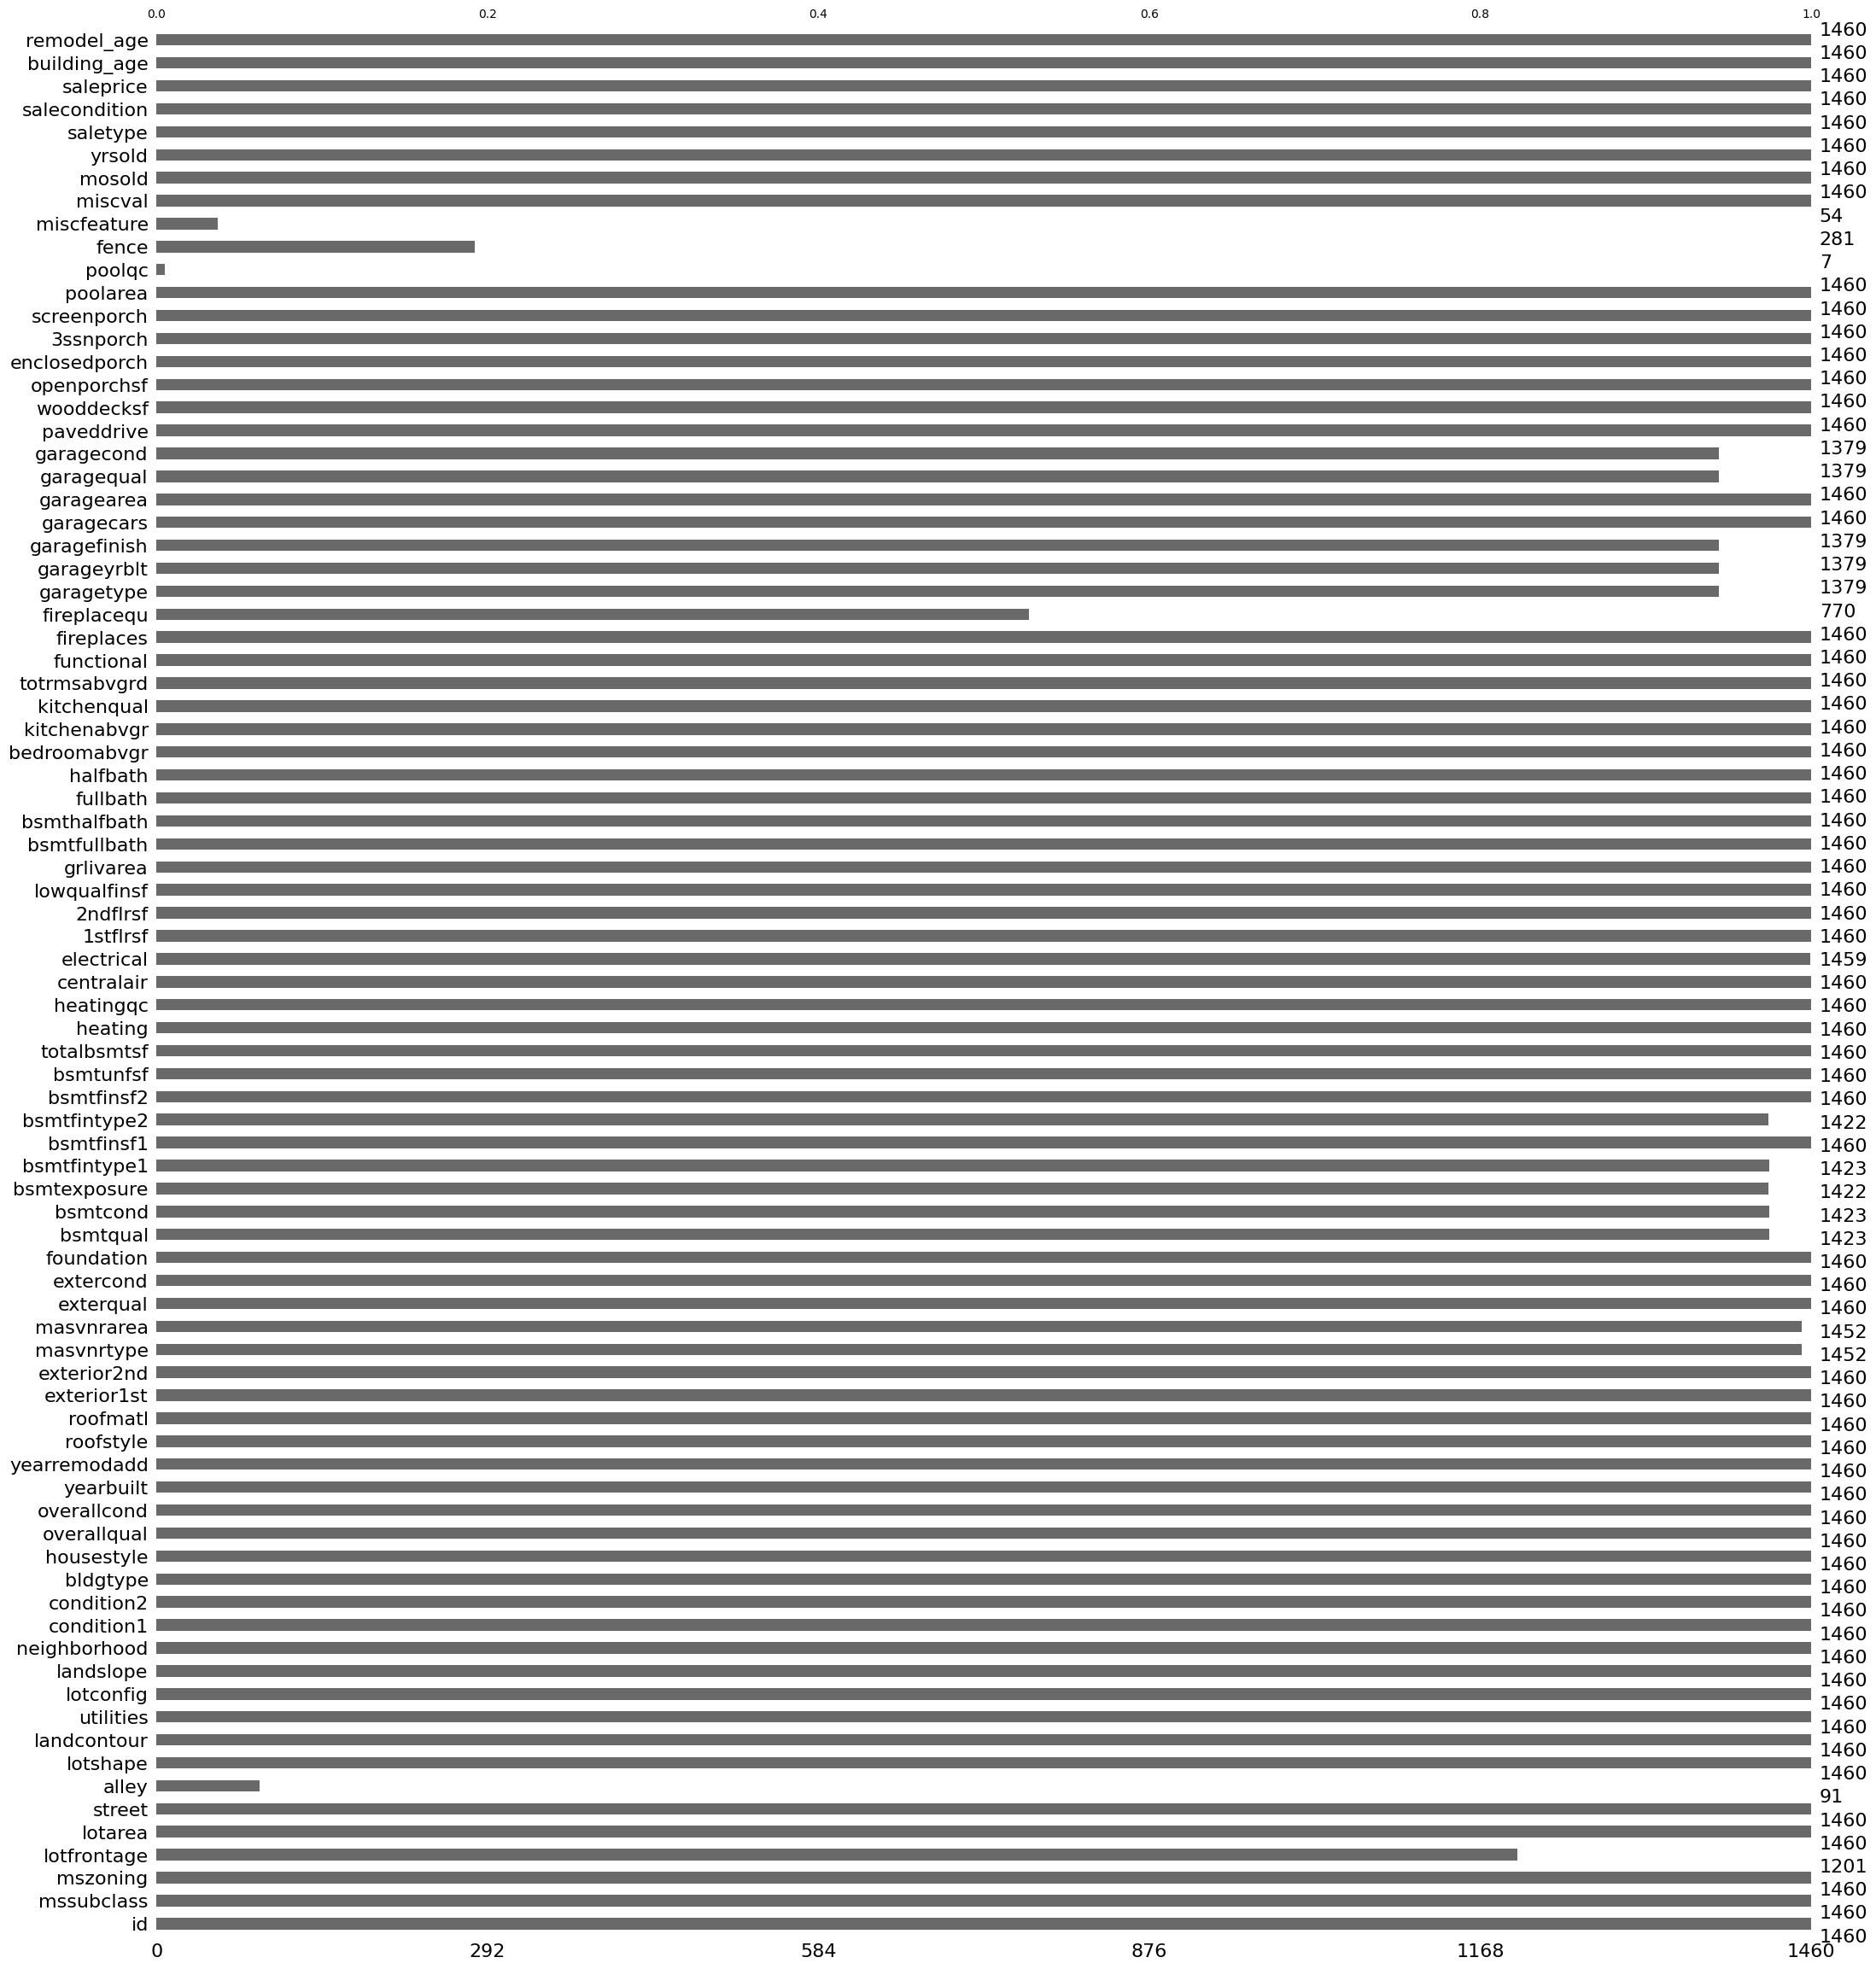

In [14]:
msno.bar(
    data,
    p=MODEL_PARAMS["MIN_COMPLETION_RATE"], # filter columns with % of missing values > 50%
)

#### Data Visualisation before data cleaning

**Sale price distribution**

In this code snippet, we provide summary statistics and information about a specific column called 'saleprice' in the DataFrame data, which contains the sale prices of houses. 

In [16]:
print('Some statistics of the house price ')
print(data['saleprice'].describe())
print()
print('house price median')
print(data['saleprice'].median())

Some statistics of the house price 
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: saleprice, dtype: float64

house price median
163000.0


By printing these summary statistics, we grasp the range of prices. The median is particularly helpful as a robust measure of central tendency. Here, the median value is 163000.

Here we generate an interactive histogram to visualize the distribution of those sale prices.

In [17]:
# Create a histogram using Plotly Express
fig = px.histogram(data_frame=data, x='saleprice', title='Sale Price Distribution')

# Customize layout
fig.update_layout(xaxis_title='Sale Price',
                  yaxis_title='Frequency',
                  width=800,
                  height=600)

fig.show()

**Studying correlation between variables**

In this code below, we compute a correlation matrix for numeric features in the data DataFrame and then create an interactive heatmap visualization using Plotly Express.

The resulting heatmap visually represents the correlation coefficients between pairs of numeric features in the dataset. Correlation coefficients indicate the strength and direction of the linear relationship between two variables. The color of each cell in the heatmap represents the correlation value, with warmer colors (such as yellow) indicating positive correlation and cooler colors (such as blue) indicating negative correlation.

In [18]:
# Calculate correlation matrix
correlation = data.select_dtypes(include=['float64', 'int64']).iloc[:, 1:].corr()

# Create a heatmap using Plotly Express
fig = px.imshow(correlation.values,
                x=correlation.index,
                y=correlation.columns,
                color_continuous_scale='Viridis',
                title='Numeric Feature heatmap')

# Customize layout
fig.update_layout(xaxis_title='Numeric Features',
                  yaxis_title='Numeric Features',
                  width=800,
                  height=600)

fig.show()

Focusing on the saleprice column for example, strong positive correlations (close to +1) such as saleprice & overallcond or saleprice & grlivarea suggest that as the saleprice feature increases, the other tends to increase as well, while strong negative correlations (close to -1) such as saleprice & remodel age or saleprice & building age suggest that as the saleprice feature increases, the other tends to decrease.

**Relation between saleprice and numeric variables**

Let's now evaluate insights into how each numeric feature correlates with the 'saleprice' column. With this code below, we can identify which features have the strongest linear relationships with the sale price.

In [19]:
corr_dict = correlation['saleprice'].to_dict()
del correlation['saleprice']
for key,val in sorted(corr_dict.items(),key=lambda x:-abs(x[1])):
    print('{0} \t : {1}' .format(key,val))

saleprice 	 : 1.0
overallqual 	 : 0.7909816005838053
grlivarea 	 : 0.7086244776126515
garagecars 	 : 0.6404091972583519
garagearea 	 : 0.6234314389183622
totalbsmtsf 	 : 0.6135805515591943
1stflrsf 	 : 0.6058521846919153
fullbath 	 : 0.5606637627484453
totrmsabvgrd 	 : 0.5337231555820284
building_age 	 : -0.5233504175468151
yearbuilt 	 : 0.5228973328794967
remodel_age 	 : -0.5090787380156288
yearremodadd 	 : 0.5071009671113866
garageyrblt 	 : 0.4863616774878596
masvnrarea 	 : 0.47749304709571444
fireplaces 	 : 0.46692883675152763
bsmtfinsf1 	 : 0.3864198062421535
lotfrontage 	 : 0.35179909657067737
wooddecksf 	 : 0.32441344456812926
2ndflrsf 	 : 0.31933380283206736
openporchsf 	 : 0.31585622711605504
halfbath 	 : 0.28410767559478256
lotarea 	 : 0.2638433538714051
bsmtfullbath 	 : 0.22712223313149427
bsmtunfsf 	 : 0.21447910554696928
bedroomabvgr 	 : 0.16821315430073963
kitchenabvgr 	 : -0.13590737084214105
enclosedporch 	 : -0.1285779579259566
screenporch 	 : 0.11144657114291112
poolar

The Sale Price strongly correlate with columns like overallqual, grlivarea, garagecars, garagearea, totalbsmtsf, 1stflrsf, fullbath, totrmsabvgrd, yearbuilt, yeareemodadd, garageyrblt, masvnrarea and fireplace.
We know now that these features might have a significant impact on the sale price prediction and can guide feature selection.

We can now use Plotly Express to create multiple scatter plots that visualize the relationship between those specific features and the saleprice column.

In [56]:
fig = px.scatter(data_frame=data, x='grlivarea', y='saleprice', title='grilivarea vs saleprice')
fig2 = px.scatter(data_frame=data, x='totrmsabvgrd', y='saleprice', title='totrmsabvgrd vs saleprice')
fig3 = px.scatter(data_frame=data, x='garagearea', y='saleprice', title='garagearea vs saleprice')
fig4 = px.scatter(data_frame=data, x='totalbsmtsf', y='saleprice', title='totalbsmtsf vs saleprice')
fig5 = px.scatter(data_frame=data, x='1stflrsf', y='saleprice', title='1stflrsf vs saleprice')
fig6 = px.scatter(data_frame=data, x='masvnrarea', y='saleprice', title='masvnrarea vs saleprice')

fig.update_layout(showlegend=False)
fig2.update_layout(showlegend=False)
fig3.update_layout(showlegend=False)
fig4.update_layout(showlegend=False)
fig5.update_layout(showlegend=False)
fig6.update_layout(showlegend=False)

fig.update_layout(height=300, width=400)
fig2.update_layout(height=300, width=400)
fig3.update_layout(height=300, width=400)
fig4.update_layout(height=300, width=400)
fig5.update_layout(height=300, width=400)
fig6.update_layout(height=300, width=400)

fig.show()
fig2.show()
fig3.show()
fig4.show()
fig5.show()
fig6.show()

In [27]:
fig = px.scatter(data_frame=data, x='yearbuilt', y='saleprice', title='yearbuilt vs saleprice')

fig.update_layout(showlegend=False)

fig.show()

**Let's now focus on categorical variables**

This code below generates a box plot that provides a visual comparison of the distribution of sale prices across different neighborhoods. Each box in the plot represents the interquartile range (IQR) of sale prices within a neighborhood, showing the median, quartiles, and potential outliers. The x-axis represents the neighborhoods, and the y-axis represents the sale prices.

In [28]:
fig = px.box(data_frame=data, x='neighborhood', y='saleprice', title='neighborhood vs saleprice')
fig.update_layout(showlegend=False, xaxis_tickangle=-90)  # Rotate x-axis labels for better visibility

fig.show()

We can observe which neighborhoods tend to have higher or lower median sale prices, the spread of prices within each neighborhood, and any potential outliers that might affect the analysis.
As we can see, we have some outliers, represented by single points, in several neighborhoods such as CollCr, NoRidge, OldTown, Gilbert and so on.

We can do the same observation with other categorical features.

In [29]:
fig = px.box(data_frame=data, x='functional', y='saleprice', title='functional vs saleprice')
fig.update_layout(showlegend=False)

fig.update_layout(height=600)

fig.show()

In [30]:
fig = px.box(data_frame=data, x='saletype', y='saleprice', title='saletype vs saleprice')
fig.update_layout(showlegend=False)

fig2 = px.box(data_frame=data, x='salecondition', y='saleprice', title='salecondition vs saleprice')
fig2.update_layout(showlegend=False)

fig.update_layout(height=800)
fig2.update_layout(height=800)

fig.show()
fig2.show()

In the folowing diagram, blue color refers to 2008, red represents 2007, green is for 2006, purple for 2009 and orange for 2010.

In [31]:
fig = px.box(data_frame=data, x='mosold', y='saleprice', color='yrsold',
             category_orders={'mosold': list(range(1, 13))},
             title='mosold vs saleprice by yrsold')

fig.update_layout(showlegend=False, yaxis_range=(0, 500000))
fig.update_yaxes(title_text='saleprice')

fig.show()

In [32]:
fig = px.box(data_frame=data, x='housestyle', y='saleprice', title='housestyle vs saleprice')
fig.update_layout(showlegend=False)

fig2 = px.box(data_frame=data, x='bldgtype', y='saleprice', title='bldgtype vs saleprice')
fig2.update_layout(showlegend=False)

fig.update_layout(height=800)
fig2.update_layout(height=800)

fig.show()
fig2.show()

In [33]:
pd.crosstab(index=data.housestyle, columns=data.heating, margins=True, margins_name="Total", dropna=False)

heating,Floor,GasA,GasW,Grav,OthW,Wall,Total
housestyle,,,,,,,
1.5Fin,0,143,7,3,0,1,154
1.5Unf,0,12,0,2,0,0,14
1Story,1,715,5,2,0,3,726
2.5Fin,0,8,0,0,0,0,8
2.5Unf,0,8,2,0,1,0,11
2Story,0,440,4,0,1,0,445
SFoyer,0,37,0,0,0,0,37
SLvl,0,65,0,0,0,0,65
Total,1,1428,18,7,2,4,1460


This is a cross-tabulation table that shows the frequency count of combinations of 'housestyle' and 'heating'. Each cell of the table contains the count of occurrences where a particular combination of 'housestyle' and 'heating' appears in the dataset. 

For example, there are 726 occurrences of the 1Story house style with GasA heating.

In [34]:
px.box(data_frame=data, x="heating", y=TARGET_NAME)

# Feature engineering

In [35]:
data.loc[:, ["yrsold", "mosold", "yearbuilt", "yearremodadd"]]

,yrsold,mosold,yearbuilt,yearremodadd
0,2008,2,2003,2003
1,2007,5,1976,1976
2,2008,9,2001,2002
3,2006,2,1915,1970
4,2008,12,2000,2000
...,...,...,...,...
1455,2007,8,1999,2000
1456,2010,2,1978,1988
1457,2010,5,1941,2006
1458,2010,4,1950,1996


In [36]:
data.yearbuilt.value_counts().head(10) #plot(kind="bar", figsize=(15, 7));

yearbuilt
2006    67
2005    64
2004    54
2007    49
2003    45
1976    33
1977    32
1920    30
1959    26
1998    25
Name: count, dtype: int64

In [37]:
filtered_data = filter_variables_by_completion_rate(data)

2023-08-22 10:09:11.344 | INFO     | src.utils:filter_variables_by_completion_rate:39 - 
 percentage of missing values: id               0.000000
mssubclass       0.000000
mszoning         0.000000
lotfrontage      0.177397
lotarea          0.000000
                   ...   
saletype         0.000000
salecondition    0.000000
saleprice        0.000000
building_age     0.000000
remodel_age      0.000000
Length: 83, dtype: float64


In [38]:
filtered_data.shape

(1460, 79)

<Axes: >

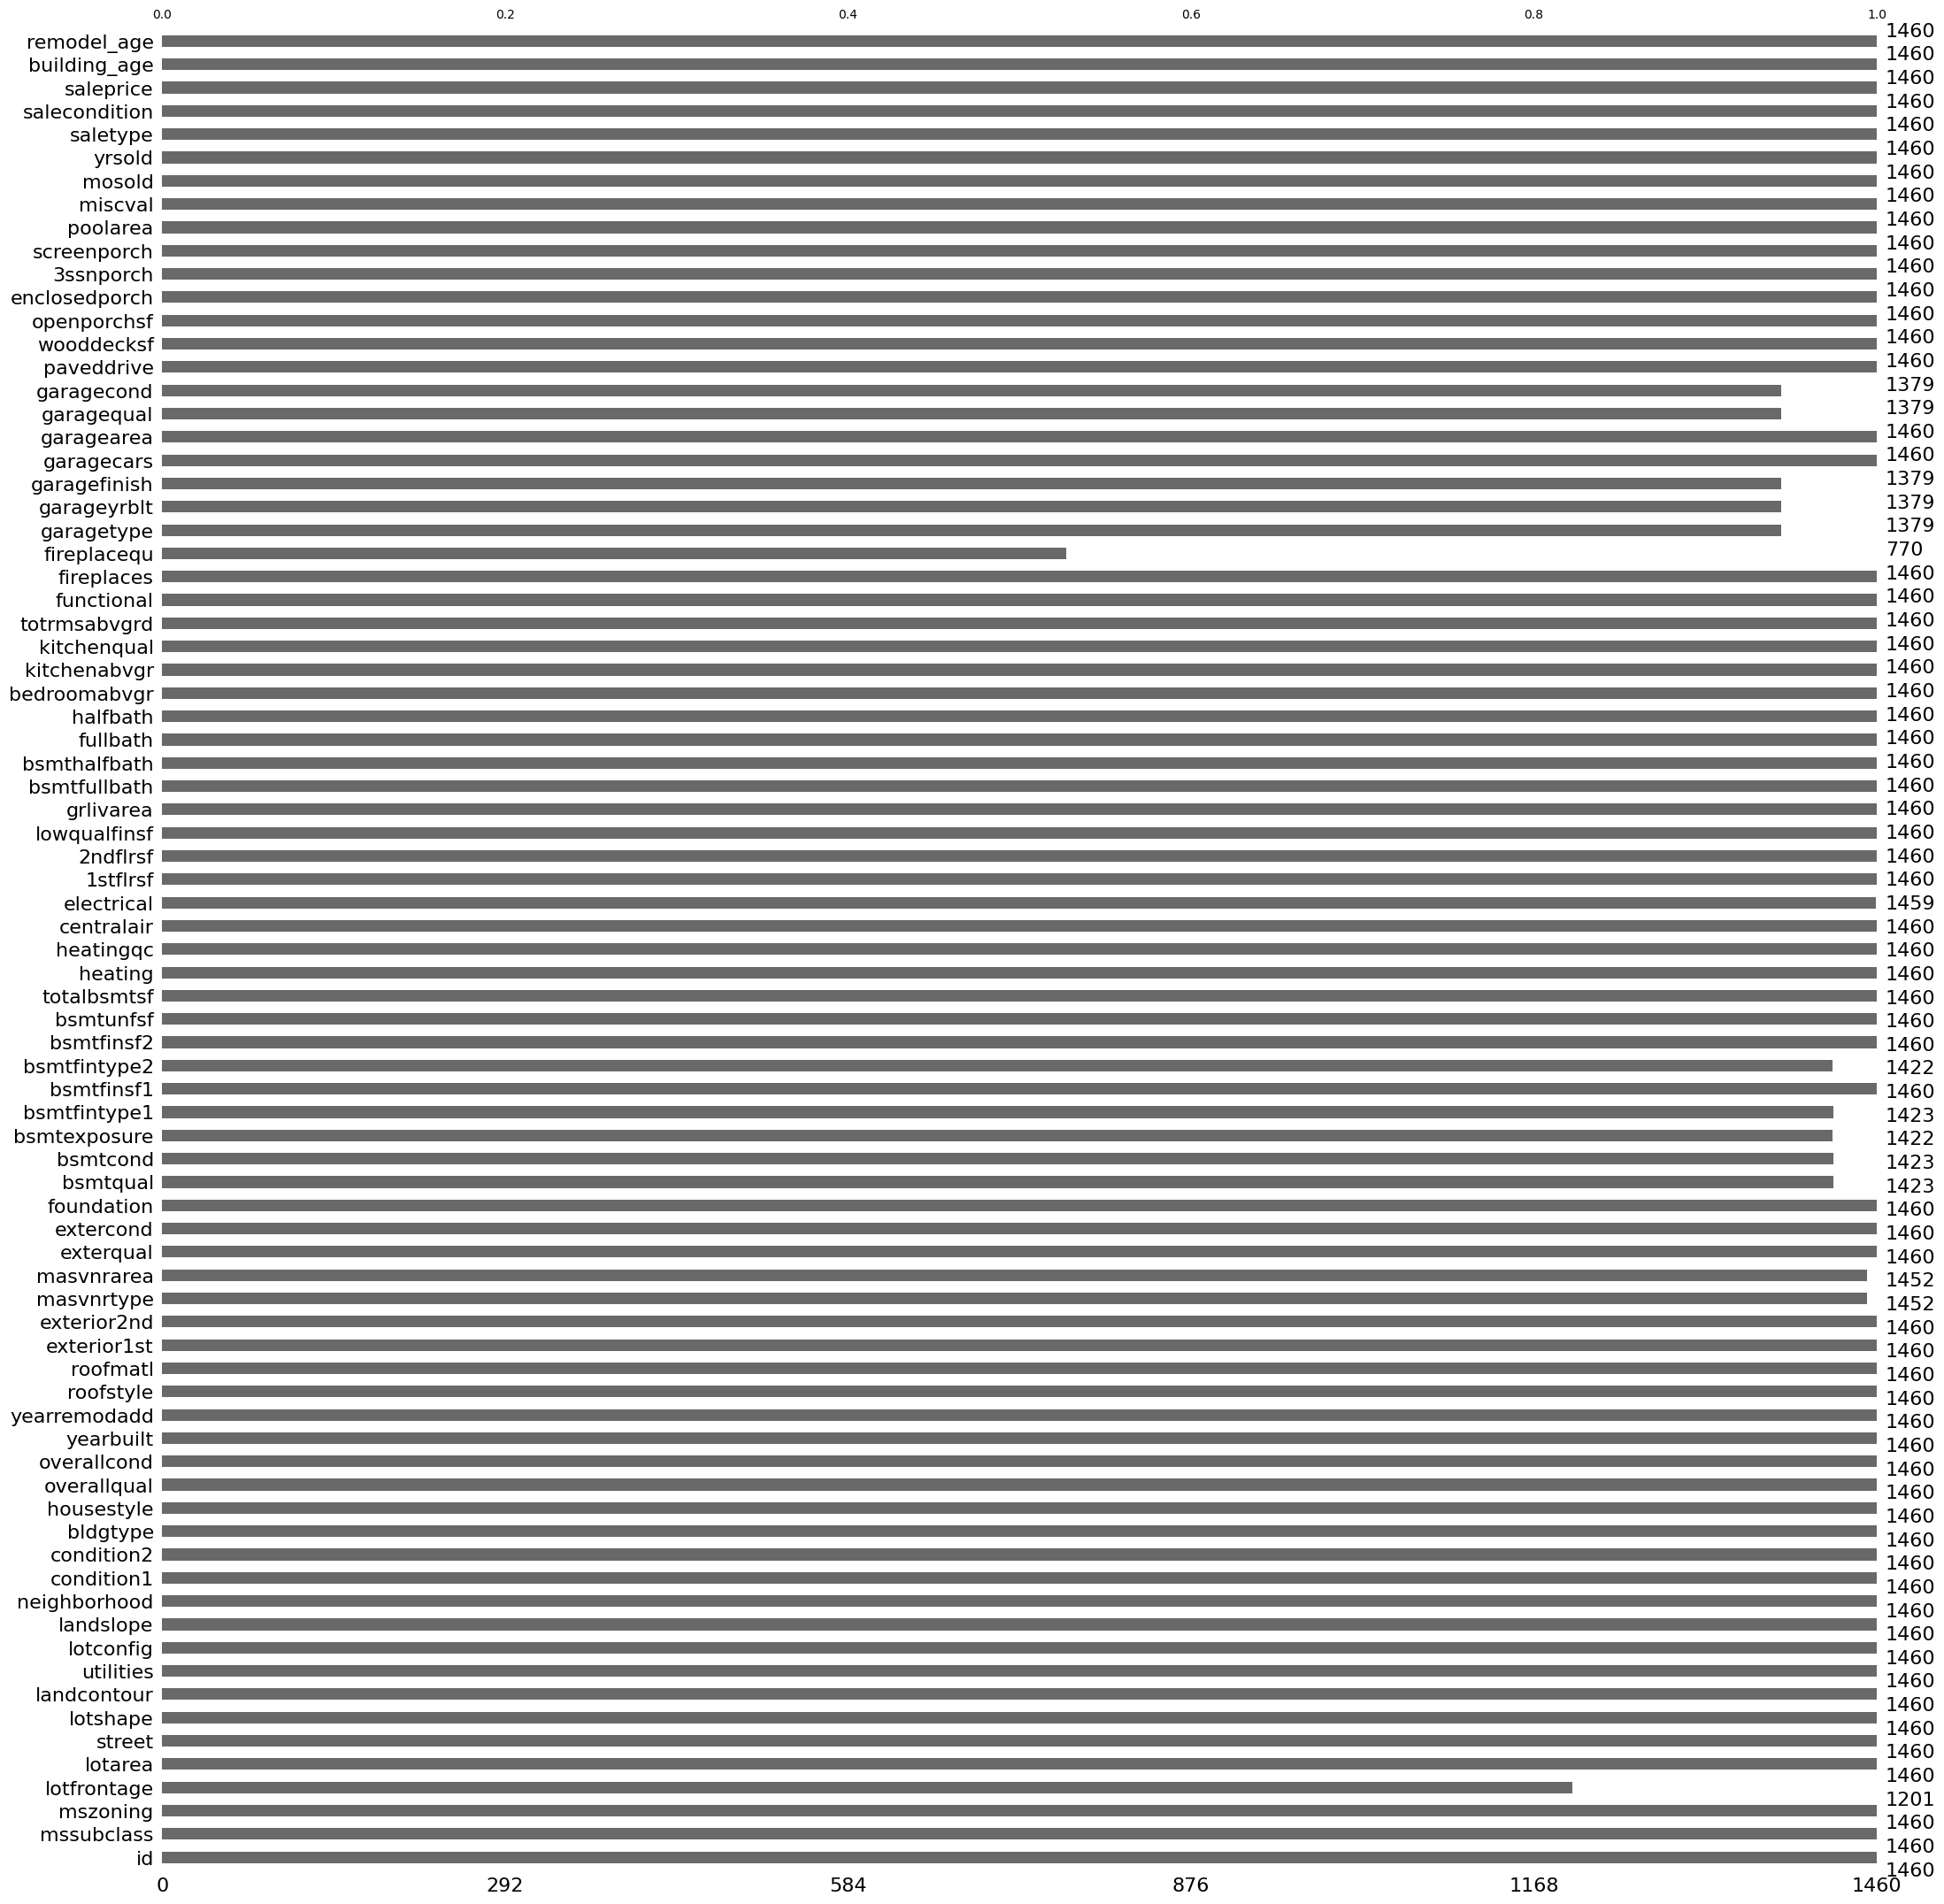

In [39]:
msno.bar(
    filtered_data,
    # filter="top",  # select only features that have a completion rate >= p
    p=MODEL_PARAMS["MIN_COMPLETION_RATE"] # filter columns with % of missing values > 50%
)

In [40]:
filtered_data=remove_single_modality_categorical_variables(filtered_data)

2023-08-22 10:09:22.477 | INFO     | src.utils:remove_single_modality_categorical_variables:68 - 
 unique values count for mszoning: 5
2023-08-22 10:09:22.479 | INFO     | src.utils:remove_single_modality_categorical_variables:68 - 
 unique values count for street: 2
2023-08-22 10:09:22.481 | INFO     | src.utils:remove_single_modality_categorical_variables:68 - 
 unique values count for lotshape: 4
2023-08-22 10:09:22.482 | INFO     | src.utils:remove_single_modality_categorical_variables:68 - 
 unique values count for landcontour: 4
2023-08-22 10:09:22.485 | INFO     | src.utils:remove_single_modality_categorical_variables:68 - 
 unique values count for utilities: 2
2023-08-22 10:09:22.486 | INFO     | src.utils:remove_single_modality_categorical_variables:68 - 
 unique values count for lotconfig: 5
2023-08-22 10:09:22.487 | INFO     | src.utils:remove_single_modality_categorical_variables:68 - 
 unique values count for landslope: 3
2023-08-22 10:09:22.488 | INFO     | src.utils:remo

In [41]:
filtered_data = filtered_data.drop("id", axis=1) #drop id by the same way

In [42]:
filtered_data

,mssubclass,mszoning,lotfrontage,lotarea,street,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,miscval,mosold,yrsold,saletype,salecondition,saleprice,building_age,remodel_age
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500,5,5
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500,31,31
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500,7,6
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000,91,36
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000,8,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Pave,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,0,8,2007,WD,Normal,175000,8,7
1456,20,RL,85.0,13175,Pave,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,0,2,2010,WD,Normal,210000,32,22
1457,70,RL,66.0,9042,Pave,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,2500,5,2010,WD,Normal,266500,69,4
1458,20,RL,68.0,9717,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,GasA,Gd,Y,FuseA,1078,0,0,1078,1,0,1,0,2,1,Gd,5,Typ,0,NaN,Attchd,1950.0,Unf,1,240,TA,TA,Y,366,0,112,0,0,0,0,4,2010,WD,Normal,142125,60,14


# Data cleaning

In [43]:
filtered_data.isna().sum().sum()

1558

In [44]:
missing_values = filtered_data.isna().sum()
columns_with_missing = missing_values[missing_values > 0]
print(columns_with_missing)

lotfrontage     259
masvnrtype        8
masvnrarea        8
bsmtqual         37
bsmtcond         37
bsmtexposure     38
bsmtfintype1     37
bsmtfintype2     38
electrical        1
fireplacequ     690
garagetype       81
garageyrblt      81
garagefinish     81
garagequal       81
garagecond       81
dtype: int64


In [50]:
categorical_columns = ['masvnrtype', 'bsmtqual', 'bsmtcond', 'bsmtexposure', 
                      'bsmtfintype1', 'bsmtfintype2', 'electrical', 'fireplacequ', 
                      'garagetype', 'garagefinish', 'garagequal', 'garagecond']

for column in categorical_columns:
    mode_imputer = SimpleImputer(strategy='most_frequent')
    filtered_data[column] = mode_imputer.fit_transform(filtered_data[[column]]).ravel()

In [52]:
numeric_columns = ['lotfrontage', 'masvnrarea', 'garageyrblt']

for column in numeric_columns:
    median_imputer = SimpleImputer(strategy='median')
    filtered_data[column] = median_imputer.fit_transform(filtered_data[[column]]).ravel()

In [54]:
missing_values = filtered_data.isna().sum()
columns_with_missing = missing_values[missing_values > 0]
print(columns_with_missing)

Series([], dtype: int64)


In [53]:
filtered_data

,mssubclass,mszoning,lotfrontage,lotarea,street,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,miscval,mosold,yrsold,saletype,salecondition,saleprice,building_age,remodel_age
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,Gd,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500,5,5
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500,31,31
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500,7,6
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000,91,36
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000,8,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Pave,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,0,8,2007,WD,Normal,175000,8,7
1456,20,RL,85.0,13175,Pave,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,0,2,2010,WD,Normal,210000,32,22
1457,70,RL,66.0,9042,Pave,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,2500,5,2010,WD,Normal,266500,69,4
1458,20,RL,68.0,9717,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,GasA,Gd,Y,FuseA,1078,0,0,1078,1,0,1,0,2,1,Gd,5,Typ,0,Gd,Attchd,1950.0,Unf,1,240,TA,TA,Y,366,0,112,0,0,0,0,4,2010,WD,Normal,142125,60,14


In [57]:
filtered_data.keys()

Index(['mssubclass', 'mszoning', 'lotfrontage', 'lotarea', 'street',
       'lotshape', 'landcontour', 'utilities', 'lotconfig', 'landslope',
       'neighborhood', 'condition1', 'condition2', 'bldgtype', 'housestyle',
       'overallqual', 'overallcond', 'yearbuilt', 'yearremodadd', 'roofstyle',
       'roofmatl', 'exterior1st', 'exterior2nd', 'masvnrtype', 'masvnrarea',
       'exterqual', 'extercond', 'foundation', 'bsmtqual', 'bsmtcond',
       'bsmtexposure', 'bsmtfintype1', 'bsmtfinsf1', 'bsmtfintype2',
       'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'heating', 'heatingqc',
       'centralair', 'electrical', '1stflrsf', '2ndflrsf', 'lowqualfinsf',
       'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath', 'halfbath',
       'bedroomabvgr', 'kitchenabvgr', 'kitchenqual', 'totrmsabvgrd',
       'functional', 'fireplaces', 'fireplacequ', 'garagetype', 'garageyrblt',
       'garagefinish', 'garagecars', 'garagearea', 'garagequal', 'garagecond',
       'paveddrive', 'wooddecksf'

As we can see, all the features with high correlation rate with the saleprice variable are included into our final dataset.

# Saving cleaned dataset

In [55]:
nom_fichier = "cleaned_data"
save_dataset(filtered_data, nom_fichier)

Dataset sauvegardé avec succès sous c:\Users\ngfar\OneDrive\Bureau\house_pricing_mlops-main\notebooks\data\input\cleaned_data.pkl
